In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[20,2,200], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


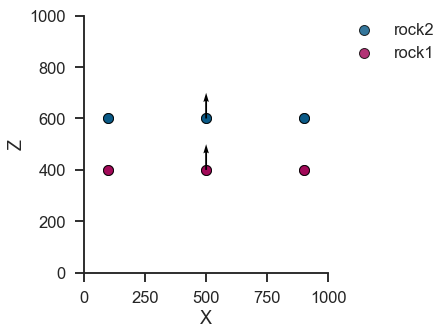

In [3]:
gp.plot.plot_data(geo_data)

In [43]:
dz = geo_data.grid.regular_grid.dz
dz

5.0

In [78]:
geo_data.surfaces.add_surfaces_values([0, 5, 0])

,surface,series,order_surfaces,isBasement,color,id,value_0
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,5
2,basement,Basement,1,True,#ffbe00,3,0


In [79]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


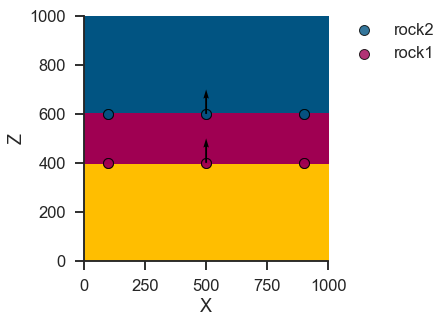

In [14]:
gp.compute_model(geo_data)
gp.plot.plot_section(geo_data, 1, show_data=True)

## Compiling gempy with PyMC3

In [80]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [81]:
i = geo_data.interpolator.get_python_input_block()

In [94]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               geo_data.interpolator.theano_graph.compute_series(), inline=False,
                                 on_unused_input='warn',
                               name='geo_model')

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Vector controlling if weights must be recomputed) of Op Subtensor{int64}(Vector controlling if weights must be recomputed, Constant{0}) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Vector controlling if weights must be recomputed) of Op Subtensor{int64}(Vector controlling if weights must be recomputed, Constant{0}) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Vector controlling if weights must be recomputed) of Op Subtensor{int64::}(Vector controlling if weights must be recomputed, Constant{0}) missing default value
  lambda entry: isinstance(ent

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:233: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{pow,no_inplace}.0) of Op Elemwise{mul,no_inplace}(InplaceDimShuffle{x,x}.0, Elemwise{pow,no_inplace}.0) missing default value
  return theano.tensor.basic.mul(other, self)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:197: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul,no_inplace}.0) of Op Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, InplaceDimShuffle{x,x}.0) missing default value
  return theano.tensor.basic.true_div(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:128: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{sub,no_inplace}.0) of Op Elemwise{add,no_inplace}(Elemwise{sub,no_inplace}.0, Elemwise{true_div,no_inplace}.0) missing default value
  return theano.tensor.basic.add(self, other)
/anaconda3/envs/gempy/lib/python3.7/si

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:177: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int32:int32:, ::}.0) of Op Elemwise{pow,no_inplace}(Subtensor{int32:int32:, ::}.0, InplaceDimShuffle{x,x}.0) missing default value
  return theano.tensor.basic.pow(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:3210: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{pow,no_inplace}.0) of Op Sum{axis=[1], acc_dtype=float64}(Elemwise{pow,no_inplace}.0) missing default value
  out = elemwise.Sum(axis=axis, dtype=dtype, acc_dtype=acc_dtype)(input)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int32:int32:, ::}.0) of Op Shape(Subtensor{int32:int32:, ::}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:464: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int64}.0) of Op ScalarFromTensor(Subtensor{int64}.0) missing default value
  return theano.tensor.scalar_from_tensor(a)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:464: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{add,no_inplace}.0) of Op ScalarFromTensor(Elemwise{add,no_inplace}.0) missing default value
  return theano.tensor.scalar_from_tensor(a)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (IncSubtensor{Set;int64:int64:, int64:int64:}.0) of Op Subtensor{int64:int64:, int64::}(IncSubtensor{Set;int64:int64:, int64:int64:}.0, Constant{0}, ScalarFromTensor.0, ScalarFromTensor.0) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/thea

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:233: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{pow,no_inplace}.0) of Op Elemwise{mul,no_inplace}(InplaceDimShuffle{x,x}.0, Elemwise{pow,no_inplace}.0) missing default value
  return theano.tensor.basic.mul(other, self)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:147: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{add,no_inplace}.0) of Op Elemwise{sub,no_inplace}(Elemwise{add,no_inplace}.0, Elemwise{mul,no_inplace}.0) missing default value
  return theano.tensor.basic.sub(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:147: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{mul,no_inplace}.0) of Op Elemwise{sub,no_inplace}(Elemwise{add,no_inplace}.0, Elemwise{mul,no_inplace}.0) missing default value
  return theano.tensor.basic.sub(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/t

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:147: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int32:int32:}.0) of Op Elemwise{sub,no_inplace}(Subtensor{int32:int32:}.0, InplaceDimShuffle{x}.0) missing default value
  return theano.tensor.basic.sub(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:572: UserWarning: Warning, Cannot compute test value: input 0 (<TensorType(float64, matrix)>) of Op AdvancedSubtensor(<TensorType(float64, matrix)>, <TensorType(int32, scalar)>, Elemwise{sub,no_inplace}.0) missing default value
  return theano.tensor.subtensor.advanced_subtensor(self, *args)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:572: UserWarning: Warning, Cannot compute test value: input 2 (Elemwise{sub,no_inplace}.0) of Op AdvancedSubtensor(<TensorType(float64, matrix)>, <TensorType(int32, scalar)>, Elemwise{sub,no_inplace}.0) missing default value
  return theano.tensor.subten

In [83]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
m = geo_data.interpolator.theano_graph.compute_series()[0][1][0:8000]
w = m.reshape(geo_data.grid.regular_grid.resolution)[10,1,:]

In [84]:
th_f = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         w,  on_unused_input='ignore')

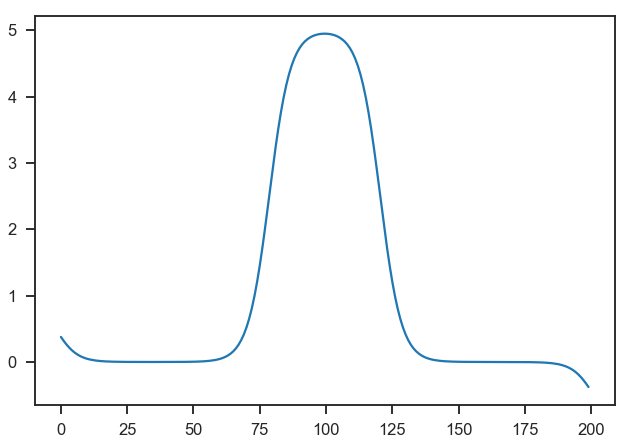

In [85]:
gempy = th_f(*geo_data.interpolator.get_python_input_block())
plt.plot(gempy)

In [86]:
gempy.sum()

209.47368411664735

In [107]:
theano.config.compute_test_value = 'warn'

th_f_g = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.grad(w.sum(), 
                                respect), on_unused_input='ignore')

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:3210: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int64, int64, ::}.0) of Op Sum{acc_dtype=float64}(Subtensor{int64, int64, ::}.0) missing default value
  out = elemwise.Sum(axis=axis, dtype=dtype, acc_dtype=acc_dtype)(input)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:2522: UserWarning: Warning, Cannot compute test value: input 0 (Sum{acc_dtype=float64}.0) of Op Elemwise{second,no_inplace}(Sum{acc_dtype=float64}.0, TensorConstant{1.0}) missing default value
  return fill(model, ret)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Sum{acc_dtype=float64}.0) of Op Shape(Sum{acc_dtype=float64}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 0 has

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0], acc_dtype=float64}.0) of Op InplaceDimShuffle{x}(Sum{axis=[0], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x}.0) of Op Shape(InplaceDimShuffle{x}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 1 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{1}.0) of Op Shape(InplaceDimShuffle{1}.0) missing default value
  shape = property(lambda self: theano.tensor.basic

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Shape.0) of Op Subtensor{int8}(Shape.0, ScalarFromTensor.0) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:4412: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{1,0}.0) of Op Shape(InplaceDimShuffle{1,0}.0) missing default value
  for x in tensors]))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Shape.0) of Op Subtensor{int8}(Shape.0, ScalarFromTensor.0) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:4412: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{1,0}.0) of Op Shape(InplaceDimShuffle{1,0}.0) missing default value
  for x 

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0, 1], acc_dtype=float64}.0) of Op InplaceDimShuffle{x,x}(Sum{axis=[0, 1], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x,x}.0) of Op Shape(InplaceDimShuffle{x,x}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 1 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Shape(Elemwise{mul}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.s

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int64:int64:}.0) of Op Elemwise{EQ}(Subtensor{int64:int64:}.0, InplaceDimShuffle{x,x}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int64:int64:}.0) of Op Elemwise{log}(Subtensor{int64:int64:}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{second}.0) of Op Elemwise{mul}(Elemwise{second}.0, Elemwise{log}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan_op.py:2543: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{sub,no_inplace}.0) of Op for{cpu,grad_of_scan_fn}(Elemwise{sub,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{::int64}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0) missing default value
  outputs = local_op(*outer_inputs)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan_op.py:2543: UserWarning: Warning, Cannot compute test value: input 1 (Subtensor{:int64:}.0) of Op for{cpu,grad_of_scan_fn}(Elemwise{sub,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{::int64}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0, Elemwise{minimum,no_inplace}.0) missing default value
  output

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:2547: UserWarning: Warning, Cannot compute test value: input 0 (Covariance SurfacePoints) of Op Elemwise{second,no_inplace}(Covariance SurfacePoints, InplaceDimShuffle{x,x}.0) missing default value
  return fill(model, ret)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:1101: UserWarning: Warning, Cannot compute test value: input 0 (IncSubtensor{Set;int64:int64:, int64:int64:}.0) of Op IncSubtensor{Set;int64:int64:, int64:int64:}(IncSubtensor{Set;int64:int64:, int64:int64:}.0, Elemwise{second,no_inplace}.0, ScalarFromTensor.0, ScalarFromTensor.0, ScalarFromTensor.0, ScalarFromTensor.0) missing default value
  return the_op(real_x, y, *real_idxargs)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:1101: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{second,no_inplace}.0) of Op IncSubtensor{Set;int64:int64:, int64:int64:}(IncSubtensor{Set;

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0, 1], acc_dtype=float64}.0) of Op InplaceDimShuffle{x,x}(Sum{axis=[0, 1], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{true_div}.0) of Op Shape(Elemwise{true_div}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 0 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x,x}.0) of Op Shape(InplaceDimShuffle{x,x}.0) missing default value
  shape = property(lambda self: theano.tens

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:2547: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{sqrt,no_inplace}.0) of Op Elemwise{second,no_inplace}(Elemwise{sqrt,no_inplace}.0, InplaceDimShuffle{x,x}.0) missing default value
  return fill(model, ret)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{second,no_inplace}.0) of Op Shape(Elemwise{second,no_inplace}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 0 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{add,no_inplace}.0) of Op Shape(Elemwise{add,no_inplace}.0) missing default value
  shape = property(lambda self: theano.

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0], acc_dtype=float64}.0) of Op InplaceDimShuffle{x}(Sum{axis=[0], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Shape(Elemwise{mul}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 0 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x}.0) of Op Shape(InplaceDimShuffle{x}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))


/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0, 1], acc_dtype=float64}.0) of Op InplaceDimShuffle{x,x}(Sum{axis=[0, 1], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Shape(Elemwise{mul}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 0 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x,x}.0) of Op Shape(InplaceDimShuffle{x,x}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.s

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:2547: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int32:int32:, ::}.0) of Op Elemwise{second,no_inplace}(Subtensor{int32:int32:, ::}.0, InplaceDimShuffle{x,x}.0) missing default value
  return fill(model, ret)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:582: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{second,no_inplace}.0) of Op IncSubtensor{Inc;::, int64}(Elemwise{second,no_inplace}.0, Elemwise{mul}.0, Constant{2}) missing default value
  gz, *rest)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:582: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{mul}.0) of Op IncSubtensor{Inc;::, int64}(Elemwise{second,no_inplace}.0, Elemwise{mul}.0, Constant{2}) missing default value
  gz, *rest)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot 

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:1647: UserWarning: Warning, Cannot compute test value: input 0 (Sum{axis=[0, 1], acc_dtype=float64}.0) of Op InplaceDimShuffle{x,x}(Sum{axis=[0, 1], acc_dtype=float64}.0) missing default value
  return DimShuffle(y.type.broadcastable, new_dims)(y)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x,x}.0) of Op Shape(InplaceDimShuffle{x,x}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 1 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Shape(Elemwise{mul}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.s

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:2547: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul,no_inplace}.0) of Op Elemwise{second,no_inplace}(Elemwise{mul,no_inplace}.0, InplaceDimShuffle{x}.0) missing default value
  return fill(model, ret)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:1101: UserWarning: Warning, Cannot compute test value: input 0 (IncSubtensor{Inc;::, :int32:}.0) of Op IncSubtensor{Set;int64:int64:, int64}(IncSubtensor{Inc;::, :int32:}.0, Elemwise{second,no_inplace}.0, ScalarFromTensor.0, ScalarFromTensor.0, Constant{8}) missing default value
  return the_op(real_x, y, *real_idxargs)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/subtensor.py:1101: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{second,no_inplace}.0) of Op IncSubtensor{Set;int64:int64:, int64}(IncSubtensor{Inc;::, :int32:}.0, Elemwise{second,no_inplace}.0, ScalarFromTensor.0, Sc

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Elemwise{mul}(Elemwise{mul}.0, Elemwise{pow}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{}.0) of Op Elemwise{mul}(InplaceDimShuffle{}.0, Elemwise{log}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{mul}.0) of Op Elemwise{mul}(Elemwise{mul}.0, Elemwise{pow}.0) missing default value
  *[transform(ipt) for ipt in node.inputs])
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:635: UserWarning: Warning, Cannot compute test value: input 2 (Elemwise{mul}.0) of O

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:306: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{x,x}.0) of Op Elemwise{identity}(InplaceDimShuffle{x,x}.0) missing default value
  Elemwise(scalar.identity)(gz))]
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/elemwise.py:306: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{identity}.0) of Op InplaceDimShuffle{}(Elemwise{identity}.0) missing default value
  Elemwise(scalar.identity)(gz))]
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:275: UserWarning: Warning, Cannot compute test value: input 0 (InplaceDimShuffle{}.0) of Op Shape(InplaceDimShuffle{}.0) missing default value
  shape = property(lambda self: theano.tensor.basic.shape(self))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/op.py:1109: UserWarning: Argument 1 has no test value
  " has no test value")
/anaconda3/envs/gempy/lib/python3.7/site-pack

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{:int64:}.0) of Op Subtensor{:int64:}(Subtensor{:int64:}.0, ScalarFromTensor.0) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 1 (ScalarFromTensor.0) of Op Subtensor{:int64:}(Subtensor{:int64:}.0, ScalarFromTensor.0) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:611: UserWarning: Warning, Cannot compute test value: input 0 (IncSubtensor{Inc;int64::}.0) of Op Subtensor{::int64}(IncSubtensor{Inc;int64::}.0, Constant{-1}) missing default value
  lambda entry: isinstance(entry, Variable)))
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan_op.py:2543: UserWarning: Warning, Cannot comput

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:128: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{add,no_inplace}.0) of Op Elemwise{add,no_inplace}(Elemwise{add,no_inplace}.0, <TensorType(float64, 3D)>) missing default value
  return theano.tensor.basic.add(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:128: UserWarning: Warning, Cannot compute test value: input 1 (<TensorType(float64, 3D)>) of Op Elemwise{add,no_inplace}(Elemwise{add,no_inplace}.0, <TensorType(float64, 3D)>) missing default value
  return theano.tensor.basic.add(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/var.py:128: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{add,no_inplace}.0) of Op Elemwise{add,no_inplace}(Elemwise{add,no_inplace}.0, <TensorType(float64, vector)>) missing default value
  return theano.tensor.basic.add(self, other)
/anaconda3/envs/gempy/lib/python3.7/site-packages

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/scan_module/scan_op.py:2543: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{sub,no_inplace}.0) of Op for{cpu,grad_of_Looping}(Elemwise{sub,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{::int64}.0, Alloc.0, Alloc.0, Alloc.0, Subtensor{::int64}.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, Alloc.0, 

In [108]:
gempy_g = th_f_g(*geo_data.interpolator.get_python_input_block())

In [115]:
gempy_g

array([[-2.08801919e-14, -2.01755887e-14, -1.41698815e+03],
       [ 2.29965334e-14,  1.69435228e-13,  1.97695172e+04],
       [-4.90600879e-14, -3.59760163e-14, -9.06231984e+03],
       [ 5.39604774e-14,  2.05678883e-13, -1.00253598e+04],
       [ 2.81862925e-13, -7.41293078e-13,  1.99454385e+04],
       [ 1.02032530e-12,  9.42876503e-13, -1.75344985e+04],
       [ 1.30667488e-13,  9.91580269e-14,  1.94228090e+04],
       [ 4.02887952e-14, -4.12366741e-13, -2.14993607e+04],
       [-3.43617191e-14,  1.01984566e-13,  1.18031168e+04],
       [-1.71343188e-13,  6.24518808e-14,  1.03722216e+04],
       [-2.08448965e-13, -3.06629149e-13, -2.44095221e+04],
       [-6.88461805e-13, -5.16879052e-13,  2.63494604e+03]])

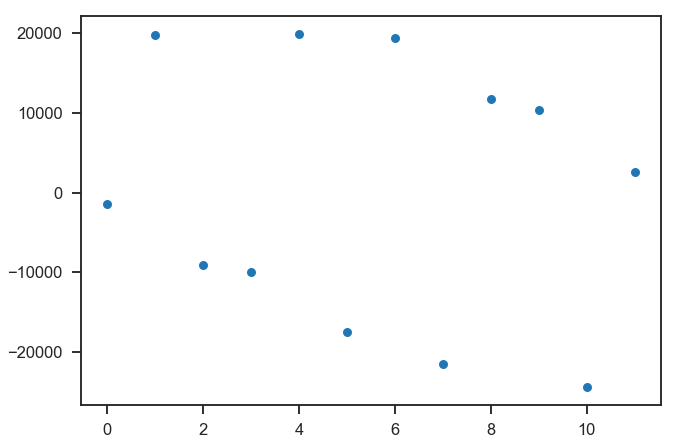

In [116]:
plt.plot(gempy_g[:, 2], 'o')

In [87]:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

In [88]:
g = geo_data.surface_points.df.groupby('id')


In [97]:
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

In [98]:
geo_data.interpolator.theano_graph.input_parameters_loop

[Position of the dips,
 Angle of every dip,
 Azimuth,
 Polarity,
 All the surface_points points at once,
 Full block matrix for faults or drift. We take 2 times len points for the faultdrift.,
 Coordinates of the grid points to interpolate,
 Values that the blocks are taking,
 Vector controlling if weights must be recomputed,
 Vector controlling if scalar matrix must be recomputed,
 Vector controlling if block matrix must be recomputed]

In [117]:
theano.config.compute_test_value = 'warn'


pm_op =  theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [w.sum()], inline=True,
                                 on_unused_input='warn',
                               name='geo_model')

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/tensor/basic.py:3210: UserWarning: Warning, Cannot compute test value: input 0 (Subtensor{int64, int64, ::}.0) of Op Sum{acc_dtype=float64}(Subtensor{int64, int64, ::}.0) missing default value
  out = elemwise.Sum(axis=axis, dtype=dtype, acc_dtype=acc_dtype)(input)


In [127]:
geo_data.interpolator.theano_graph.input_parameters_loop

[Position of the dips,
 Angle of every dip,
 Azimuth,
 Polarity,
 All the surface_points points at once,
 Full block matrix for faults or drift. We take 2 times len points for the faultdrift.,
 Coordinates of the grid points to interpolate,
 Values that the blocks are taking,
 Vector controlling if weights must be recomputed,
 Vector controlling if scalar matrix must be recomputed,
 Vector controlling if block matrix must be recomputed]

In [128]:

theano.config.compute_test_value = 'ignore'

geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:8000]], inline=True,
                                 on_unused_input='warn',
                               name='geo_model')

In [102]:
geo_data.grid.regular_grid.resolution

array([ 20,   2, 200])

In [146]:
%matplotlib notebook
import theano

import theano.tensor as tt
theano.config.compute_test_value = 'warn'
# We convert a python variable to theano.shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

with pm.Model() as model2:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((20, 2, 200))[10,1,:]
   # thickness = pm.Deterministic('thickness', well.sum())
   # thickness.name = 'thickness'
    thickness = well.sum()
    a = pm.Normal('y', mu=thickness, sd=20, observed=120)
    # b = pm.Metropolis()
    trace = pm.sample(1000, chains=1, tune=500,
                   #  step =b,
                    compute_convergence_checks=True)
         #   live_plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [rock1, rock2]
100%|██████████| 1500/1500 [19:29<00:00,  1.62it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


<IPython.core.display.Javascript object>


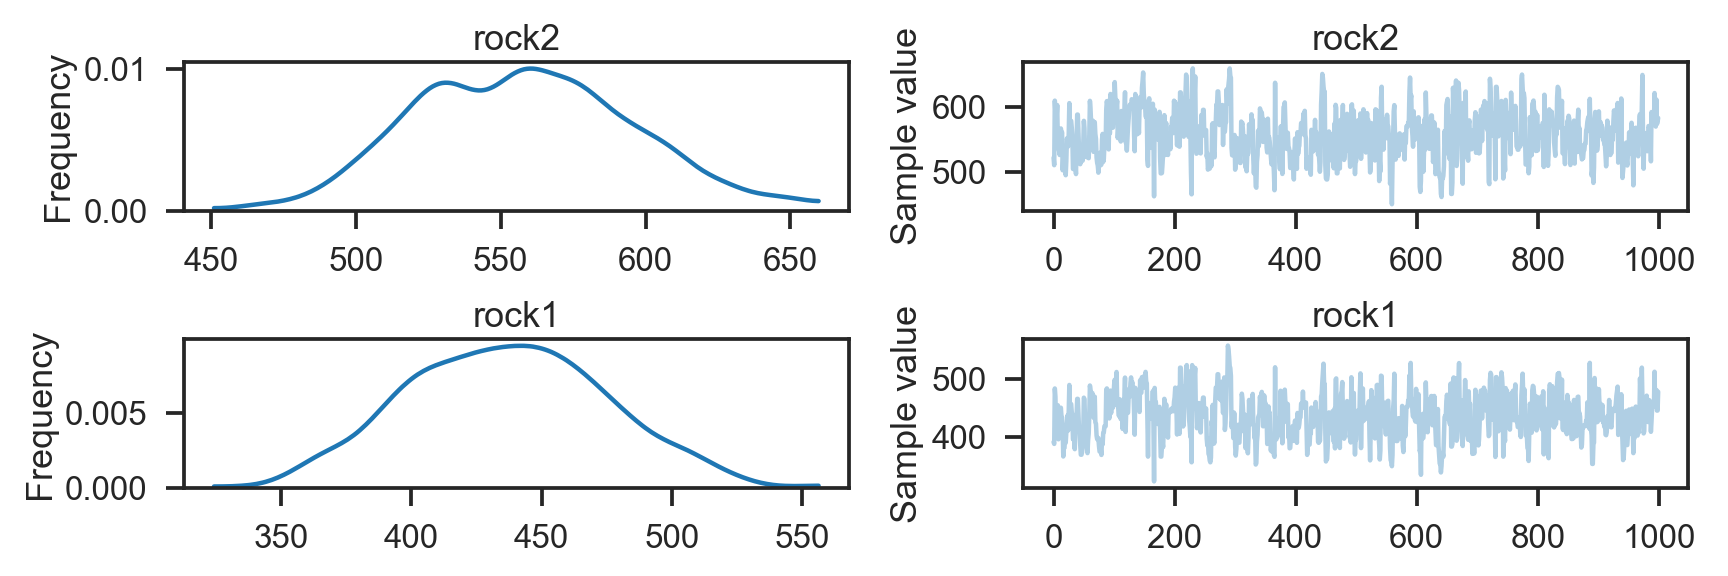

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba18664e48>,
      dtype=object)

In [147]:

pm.traceplot(trace)